In [ ]:
# Import Modules
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
# Set the device globally
torch.set_default_device(device)

Device:  cpu


In [ ]:
# Load Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5),)])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train =True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(0.8 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


100%|██████████| 26421880/26421880 [00:06<00:00, 4147054.02it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 148835.93it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2598698.31it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13386408.55it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



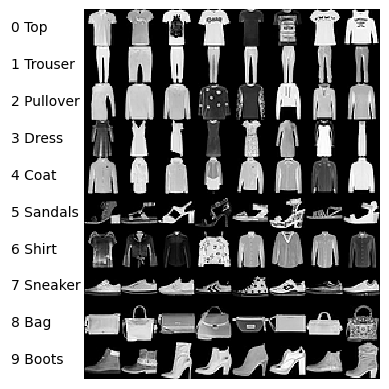

In [ ]:
# Present Data
dataiter = iter(trainloader)

classes =  {0: 'Top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandals',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Boots'}
objects = list(classes.values())

temp_list = {}
for i in range(10):
  temp_list[i] = []

def is_full(temp_list):
  for v in temp_list.values():
    if len(v) < 8:
      return False
  return True

not_finished = True
while not_finished:
  images, labels = next(dataiter)
  for i, label in enumerate(labels):
    if is_full(temp_list):
      not_finished = False
      break
    if len(temp_list[int(label)]) < 8:
      temp_list[int(label)].append(images[i])

i = 0
j = 0
list_images = np.ones((28*10,28*10))

for v in temp_list.values():
  temp = []
  for img in v:
    list_images[28*j:28*(j+1),28*i+28*2:28*(i+1)+28*2] = img.reshape(28,28)
    i += 1
  i = 0
  j += 1
plt.imshow(list_images, interpolation = 'nearest', cmap='gray')
plt.axis('off')

i = 16
for k,v in classes.items():
  plt.text(0, i, str(k) + ' ' + v, fontsize=10)
  i += 28
plt.show()

In [ ]:
def calc_correct(predictions, lables):
  return predictions.argmax(1).eq(lables).sum().item()

# Train the Model
def train(model, trainloader, testloader, total_epochs=50):
  print(f'Training model {model.model_name}')
  losses = []
  train_accuracies = []
  test_accuracies = []
  total_epochs = total_epochs
  for epoch in range(total_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total_correct = 0
      total = 0
      dataiter = iter(trainloader)
      for data in dataiter:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          model.optimizer.zero_grad()

          # forward + backward + optimize
          if device == "cuda":
            inputs = inputs.to('cuda')
          outputs = model(inputs)
          loss = model.criterion(outputs, labels)
          loss.backward()
          model.optimizer.step()

          # collect statistics
          running_loss += loss.item()
          total_correct += calc_correct(outputs, labels)
          total += labels.size(0)

      losses.append(running_loss)
      if model.model_name == 'lenet5_dropout':
        model.eval()
        train_accuracy = get_accuracy(model, trainloader)
        model.train()
      else:
        train_accuracy = get_accuracy(model, trainloader)
      test_accuracy = get_accuracy(model, testloader)

      train_accuracies.append(train_accuracy)
      test_accuracies.append(test_accuracy)
      print(f'Epoch {epoch + 1}/{total_epochs}; Train Loss: {running_loss:.2f}; Train Accuracy: {train_accuracy:.2f}; Test Accuracy: {test_accuracy:.2f}')

      # Save model
      path = f'./{model.model_name}.pt'
      torch.save(model.state_dict(), path)

  print('Finished Training')

  return losses, train_accuracies, test_accuracies

def get_accuracy(model, dataloader):
  total_correct = 0
  total = 0

  with torch.no_grad():
    dataiter = iter(dataloader)
    for data in dataiter:
        inputs, labels = data

        # calculate outputs by running images through the network
        if device == "cuda":
          inputs = inputs.to('cuda')
        outputs = model(inputs)

        total_correct += calc_correct(outputs, labels)
        total += labels.size(0)

  return total_correct/total

def test(model, dataloader, test_size=10):
  if test_size > 64:
    print("Please enter test_size smaller than 64")
    return

  print(f"Test model {model.model_name}")
  with torch.no_grad():
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs, labels = data

    if device == "cuda":
        inputs = inputs.to('cuda')
    outputs = model(inputs)
    predictions = outputs.argmax(1)

    fig = plt.figure(figsize=(2*test_size, 20))
    for i in range(test_size):
      fig.add_subplot(test_size, 1, i+1)
      plt.imshow(inputs[i].reshape(28,28), cmap='gray')
      plt.axis('off')
      pre_label = classes[int(predictions[i])]
      rea_label = classes[int(labels[i])]

      if pre_label != rea_label:
        color = 'red'
      else:
        color = 'green'
      plt.title(f'Real: {rea_label}, Predicted: {pre_label}', color=color)
    plt.show()

In [ ]:
# Build Model
class LeNet5(nn.Module):
  def __init__(self, n_classes=10):
    super().__init__()
    self.model_name = 'lenet5'
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = None

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
    self.tanh = nn.Tanh()
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.flat = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(in_features=120 , out_features=84)
    self.fc2 = nn.Linear(in_features=84 , out_features=n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.tanh(x)
    x = self.fc2(x)
    return x

lenet5 = LeNet5()
if device == "cuda":
  lenet5 = lenet5.cuda()
summary(lenet5, (1, 28, 28))

lenet5.optimizer = optim.Adam(lenet5.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
           Flatten-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
# Build Model with Dropout
class LeNet5Dropout(nn.Module):
  def __init__(self, n_classes=10):
    super().__init__()
    self.model_name = 'lenet5_dropout'
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = None

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
    self.tanh = nn.Tanh()
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout()
    self.flat = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(in_features=120 , out_features=84)
    self.fc2 = nn.Linear(in_features=84 , out_features=n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.tanh(x)
    x = self.fc2(x)
    return x

lenet5_dropout = LeNet5Dropout()
if device == "cuda":
  lenet5_dropout = lenet5_dropout.cuda()
summary(lenet5_dropout, (1, 28, 28))

# Define Optimizer
lenet5_dropout.optimizer = optim.Adam(lenet5_dropout.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Dropout-7             [-1, 16, 5, 5]               0
            Conv2d-8            [-1, 120, 1, 1]          48,120
           Flatten-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             Tanh-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [ ]:
# Build Model with Weight Decay
class LeNet5WeightDecay(nn.Module):
  def __init__(self, n_classes=10):
    super().__init__()
    self.model_name = 'lenet5_weight_decay'
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = None

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
    self.tanh = nn.Tanh()
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.flat = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(in_features=120 , out_features=84)
    self.fc2 = nn.Linear(in_features=84 , out_features=n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.tanh(x)
    x = self.fc2(x)
    return x

lenet5_weight_decay = LeNet5WeightDecay()
if device == "cuda":
  lenet5_weight_decay = lenet5_weight_decay.cuda()
summary(lenet5_weight_decay, (1, 28, 28))

# Define Optimizer
lenet5_weight_decay.optimizer = optim.Adam(lenet5_weight_decay.parameters(), lr=0.001, weight_decay=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
           Flatten-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
# Build Model with batch normalization
class LeNet5BaNorm(nn.Module):
  def __init__(self, n_classes=10):
    super().__init__()
    self.model_name = 'lenet5_batch_normalization'
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = None

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
    self.banorm1 = nn.BatchNorm2d(6)
    self.banorm2 = nn.BatchNorm2d(16)
    self.banorm3 = nn.BatchNorm2d(120)
    self.tanh = nn.Tanh()
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.flat = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(in_features=120 , out_features=84)
    self.fc2 = nn.Linear(in_features=84 , out_features=n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.banorm1(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.banorm2(x)
    x = self.tanh(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.banorm3(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.tanh(x)
    x = self.fc2(x)
    return x

lenet5_batch_normalization = LeNet5BaNorm()
if device == "cuda":
  lenet5_batch_normalization = lenet5_batch_normalization.cuda()
summary(lenet5_batch_normalization, (1, 28, 28))

# Define Loss function and Optimizer
lenet5_batch_normalization.optimizer = optim.Adam(lenet5_batch_normalization.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              Tanh-3            [-1, 6, 28, 28]               0
         AvgPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              Tanh-7           [-1, 16, 10, 10]               0
         AvgPool2d-8             [-1, 16, 5, 5]               0
            Conv2d-9            [-1, 120, 1, 1]          48,120
      BatchNorm2d-10            [-1, 120, 1, 1]             240
          Flatten-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             Tanh-13                   [-1, 84]               0
           Linear-14                   

Training model lenet5
Epoch 1/50; Train Loss: 464.85; Train Accuracy: 0.83; Test Accuracy: 0.82
Epoch 2/50; Train Loss: 320.32; Train Accuracy: 0.86; Test Accuracy: 0.85
Epoch 3/50; Train Loss: 285.50; Train Accuracy: 0.87; Test Accuracy: 0.85
Epoch 4/50; Train Loss: 266.54; Train Accuracy: 0.87; Test Accuracy: 0.85
Epoch 5/50; Train Loss: 253.00; Train Accuracy: 0.88; Test Accuracy: 0.86
Epoch 6/50; Train Loss: 241.12; Train Accuracy: 0.89; Test Accuracy: 0.87
Epoch 7/50; Train Loss: 232.61; Train Accuracy: 0.89; Test Accuracy: 0.87
Epoch 8/50; Train Loss: 223.49; Train Accuracy: 0.90; Test Accuracy: 0.87
Epoch 9/50; Train Loss: 216.27; Train Accuracy: 0.90; Test Accuracy: 0.88
Epoch 10/50; Train Loss: 211.21; Train Accuracy: 0.90; Test Accuracy: 0.88
Epoch 11/50; Train Loss: 204.64; Train Accuracy: 0.90; Test Accuracy: 0.87
Epoch 12/50; Train Loss: 201.89; Train Accuracy: 0.90; Test Accuracy: 0.88
Epoch 13/50; Train Loss: 195.17; Train Accuracy: 0.91; Test Accuracy: 0.88
Epoch 14/50;

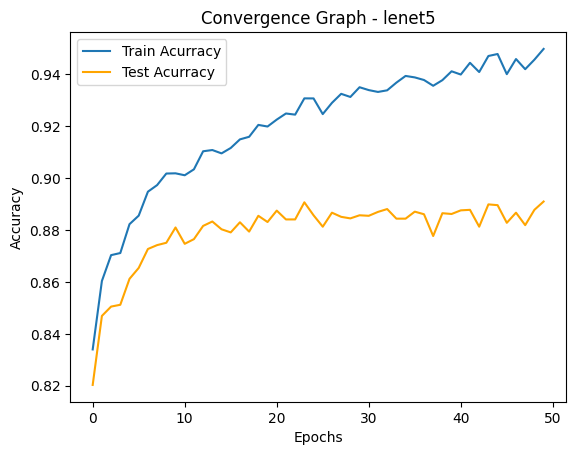

Training model lenet5_dropout
Epoch 1/50; Train Loss: 512.29; Train Accuracy: 0.83; Test Accuracy: 0.79
Epoch 2/50; Train Loss: 377.12; Train Accuracy: 0.85; Test Accuracy: 0.81
Epoch 3/50; Train Loss: 347.17; Train Accuracy: 0.86; Test Accuracy: 0.82
Epoch 4/50; Train Loss: 332.23; Train Accuracy: 0.86; Test Accuracy: 0.83
Epoch 5/50; Train Loss: 318.95; Train Accuracy: 0.87; Test Accuracy: 0.83
Epoch 6/50; Train Loss: 313.37; Train Accuracy: 0.87; Test Accuracy: 0.83
Epoch 7/50; Train Loss: 308.06; Train Accuracy: 0.87; Test Accuracy: 0.83
Epoch 8/50; Train Loss: 300.63; Train Accuracy: 0.88; Test Accuracy: 0.84
Epoch 9/50; Train Loss: 297.92; Train Accuracy: 0.88; Test Accuracy: 0.84
Epoch 10/50; Train Loss: 295.09; Train Accuracy: 0.88; Test Accuracy: 0.85
Epoch 11/50; Train Loss: 291.22; Train Accuracy: 0.88; Test Accuracy: 0.85
Epoch 12/50; Train Loss: 290.10; Train Accuracy: 0.88; Test Accuracy: 0.85
Epoch 13/50; Train Loss: 288.32; Train Accuracy: 0.88; Test Accuracy: 0.85
Epoc

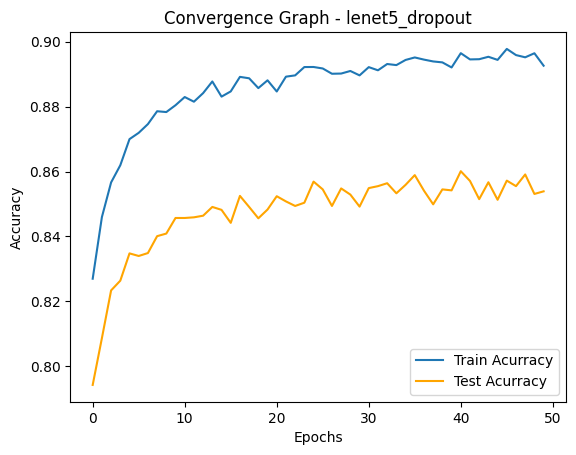

Training model lenet5_weight_decay
Epoch 1/50; Train Loss: 468.19; Train Accuracy: 0.83; Test Accuracy: 0.82
Epoch 2/50; Train Loss: 325.05; Train Accuracy: 0.85; Test Accuracy: 0.84
Epoch 3/50; Train Loss: 294.39; Train Accuracy: 0.85; Test Accuracy: 0.84
Epoch 4/50; Train Loss: 277.67; Train Accuracy: 0.87; Test Accuracy: 0.85
Epoch 5/50; Train Loss: 269.30; Train Accuracy: 0.88; Test Accuracy: 0.86
Epoch 6/50; Train Loss: 259.75; Train Accuracy: 0.89; Test Accuracy: 0.87
Epoch 7/50; Train Loss: 253.01; Train Accuracy: 0.88; Test Accuracy: 0.87
Epoch 8/50; Train Loss: 247.38; Train Accuracy: 0.89; Test Accuracy: 0.87
Epoch 9/50; Train Loss: 240.13; Train Accuracy: 0.88; Test Accuracy: 0.86
Epoch 10/50; Train Loss: 236.53; Train Accuracy: 0.89; Test Accuracy: 0.88
Epoch 11/50; Train Loss: 233.55; Train Accuracy: 0.89; Test Accuracy: 0.88
Epoch 12/50; Train Loss: 227.67; Train Accuracy: 0.89; Test Accuracy: 0.88
Epoch 13/50; Train Loss: 226.10; Train Accuracy: 0.89; Test Accuracy: 0.88

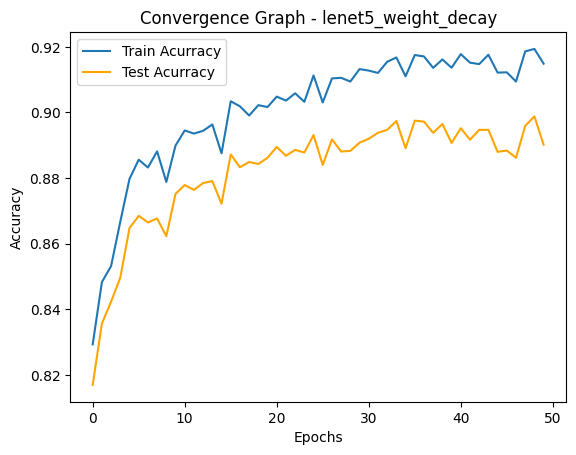

Training model lenet5_batch_normalization
Epoch 1/50; Train Loss: 365.59; Train Accuracy: 0.86; Test Accuracy: 0.85
Epoch 2/50; Train Loss: 263.85; Train Accuracy: 0.89; Test Accuracy: 0.87
Epoch 3/50; Train Loss: 236.13; Train Accuracy: 0.90; Test Accuracy: 0.88
Epoch 4/50; Train Loss: 216.80; Train Accuracy: 0.90; Test Accuracy: 0.88
Epoch 5/50; Train Loss: 204.58; Train Accuracy: 0.91; Test Accuracy: 0.89
Epoch 6/50; Train Loss: 192.64; Train Accuracy: 0.91; Test Accuracy: 0.89
Epoch 7/50; Train Loss: 184.02; Train Accuracy: 0.91; Test Accuracy: 0.88
Epoch 8/50; Train Loss: 176.97; Train Accuracy: 0.92; Test Accuracy: 0.89
Epoch 9/50; Train Loss: 169.91; Train Accuracy: 0.92; Test Accuracy: 0.89
Epoch 10/50; Train Loss: 163.91; Train Accuracy: 0.92; Test Accuracy: 0.89
Epoch 11/50; Train Loss: 158.37; Train Accuracy: 0.93; Test Accuracy: 0.90
Epoch 12/50; Train Loss: 151.21; Train Accuracy: 0.93; Test Accuracy: 0.90
Epoch 13/50; Train Loss: 148.31; Train Accuracy: 0.93; Test Accurac

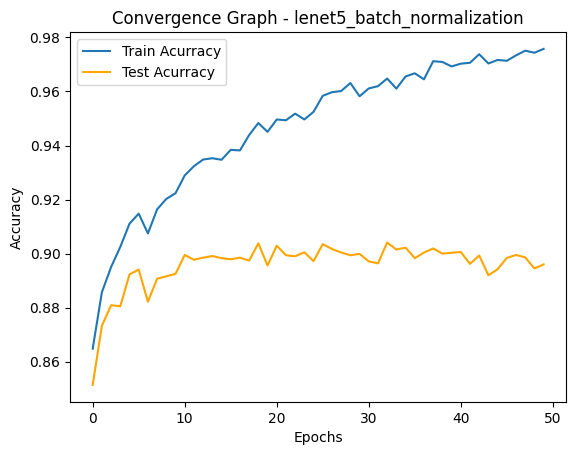

In [ ]:
models = [lenet5, lenet5_dropout, lenet5_weight_decay, lenet5_batch_normalization]
train_accuracies = {}
test_accuracies = {}

for model in models:
  loss, train_acc, test_acc = train(model, trainloader, testloader)
  train_accuracies[model.model_name] = train_acc[-1]
  test_accuracies[model.model_name] = test_acc[-1]

  plt.figure()
  plt.plot(train_acc, label='Train Acurracy')
  plt.plot(test_acc, label='Test Acurracy', color='orange')
  plt.title(f'Convergence Graph - {model.model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# Summarize Table
from prettytable import PrettyTable

t = PrettyTable(["Model","Train Accuracy [%]", "Test Accuracy [%]"])
for k in train_accuracies.keys():
  t.add_row([k, round(train_accuracies[k]*100,2), round(test_accuracies[k]*100,2)])

print("Summarizes all 8 final accuracies:")
print(t)

Summarizes all 8 final accuracies:
+----------------------------+--------------------+-------------------+
|           Model            | Train Acuuracy [%] | Test Accuracy [%] |
+----------------------------+--------------------+-------------------+
|           lenet5           |       94.98        |        89.1       |
|       lenet5_dropout       |       89.26        |       85.39       |
|    lenet5_weight_decay     |       91.49        |       89.02       |
| lenet5_batch_normalization |       97.58        |        89.6       |
+----------------------------+--------------------+-------------------+


Test model lenet5


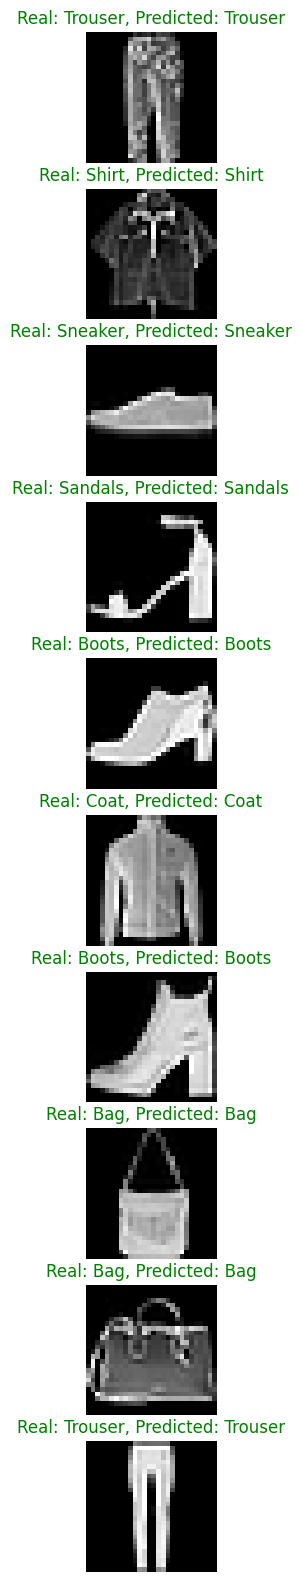

Test model lenet5_dropout


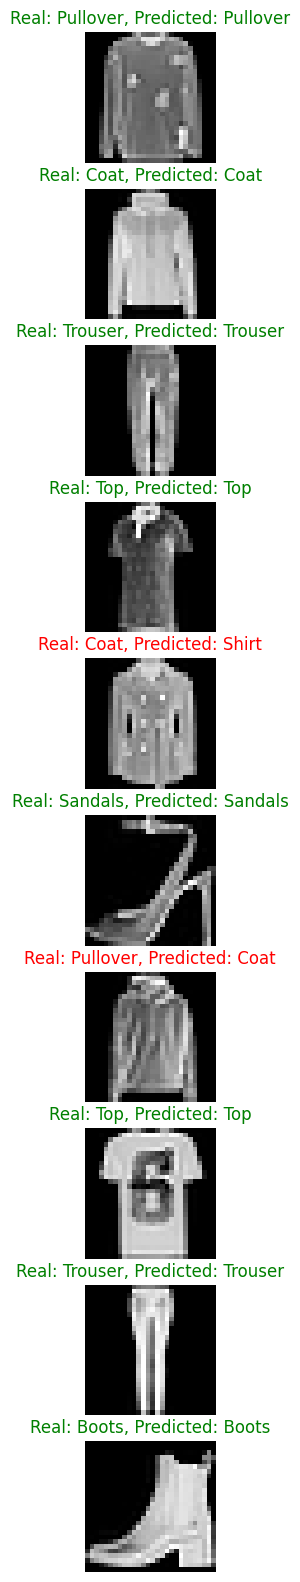

Test model lenet5_weight_decay


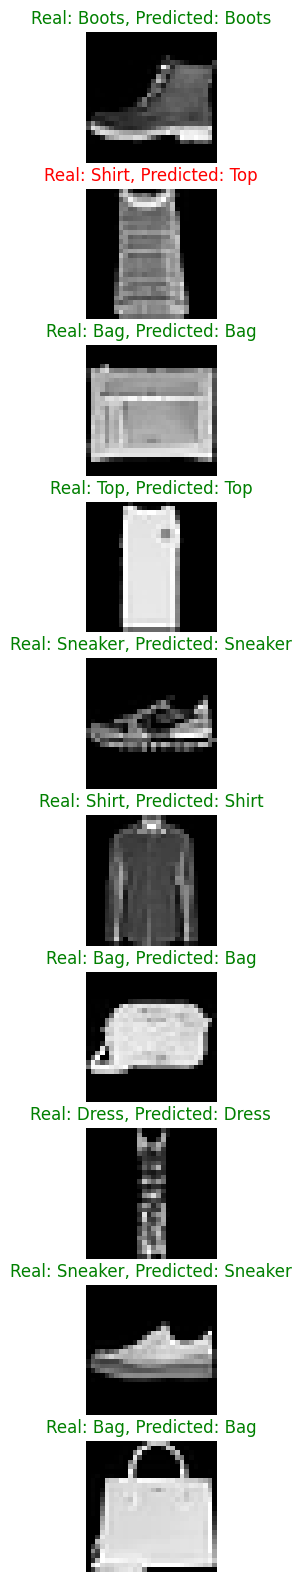

Test model lenet5_batch_normalization


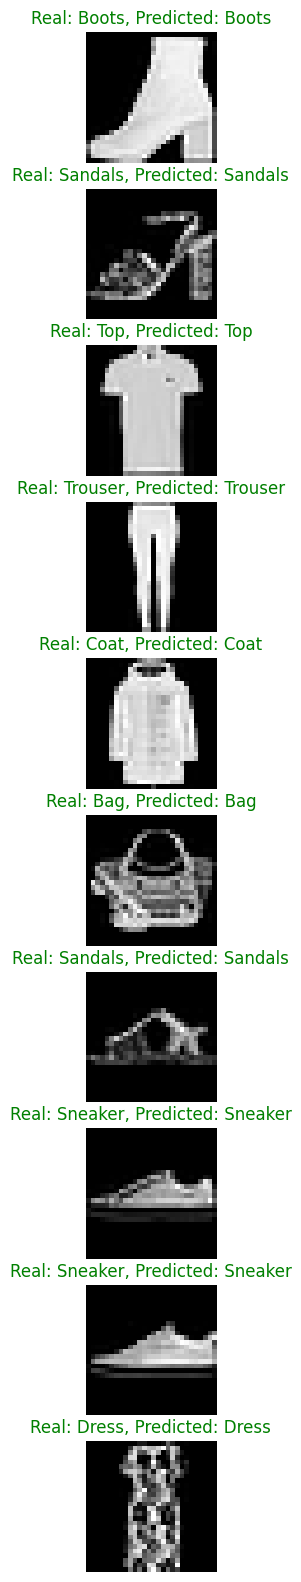

In [ ]:
# Test model
model = LeNet5()
model.load_state_dict(torch.load(f'./{model.model_name}.pt'))
test(model, testloader)

model = LeNet5Dropout()
model.load_state_dict(torch.load(f'./{model.model_name}.pt'))
test(model, testloader)

model = LeNet5WeightDecay()
model.load_state_dict(torch.load(f'./{model.model_name}.pt'))
test(model, testloader)

model = LeNet5BaNorm()
model.load_state_dict(torch.load(f'./{model.model_name}.pt'))
test(model, testloader)